In [1]:
import pandas as pd
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
from mpl_toolkits import mplot3d
import random
import plotly.express as px
import plotly.colors as plt_colors
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = "vscode"
from scipy.spatial import distance
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines, CyclicCubicSplines
from statsmodels.genmod.families import Gaussian
from fastkde import fastKDE
from scipy import stats
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.decomposition import PCA

import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from matplotlib.ticker import MultipleLocator


conn_url = sqlalchemy.engine.URL.create(
    drivername='postgresql+psycopg2',
    username='jericho',
    password='Ilikesony1!',
    host='holocron.local',
    database='postgres'
)

eng = create_engine(conn_url)

# Data Ingestion

In [2]:
codes = {
'1_agg_H': 'Personal Care', 
'2_agg_H': 'Household Activities', 
'3_agg_H': 'Care for HH Members', 
'4_agg_H': 'Care for NH Members', 
'5_agg_H': 'Work', 
'6_agg_H': 'Education', 
'7_agg_H': 'Consumer Purchases', 
'8_agg_H': 'Prof. & Pers. Services',
'9_agg_H': 'Household Services', 
'10_agg_H': 'Govt Services & Civic', 
'11_agg_H': 'Eating & Drinking', 
'12_agg_H': 'Socializing & Leisure', 
'13_agg_H': 'Sports, Exrc & Rec', 
'14_agg_H': 'Religious & Spiritual', 
'15_agg_H': 'Volunteer Activities', 
'16_agg_H': 'Phone calls', 
'18_agg_H': 'Traveling', 
'ALL_TU_H': 'Any Activity', 
'CARE_TU_H': 'Care-Related Activities', 
'SOCIAL_TU_H': 'Any Social Activity'
}

who_list = ['alone', 'hh_fam', 'hh_nonfam', 'nh_fam', 'nh_friend', 'nh_acq', 'nh_other', 'nh_cowork', 'nh_cust']


In [3]:
def pca_df_subset(df, vars):
    df_stringency = df[['GTCBSA']+vars].copy()
    pca = PCA(n_components=len(vars))
    result = pca.fit_transform(df_stringency[vars])
    pca_df = pd.DataFrame(data = result, columns = [f'pc_{i}' for i in range(len(vars))])
    variance_captured = list(pca.explained_variance_)
    variance_captured = [i/sum(variance_captured) for i in variance_captured]
    return pca_df

def collapse_time(df, ref, selection):
    df = df[df[ref].isin(selection)].drop(ref, axis=1)
    df = df.groupby('GTCBSA').mean().reset_index()
    return df

def replace_cols_with_pc(df, vars, pc_vars, pcs, string):
    pca_df = pca_df_subset(df, pc_vars)
    df = df.drop(vars, axis=1)
    for i in range(pcs):
        df[f'{string}_pc{i}'] = pca_df[f'pc_{i}']
    return df

def split_df(df, var, n):
    df = df.sort_values(var)
    df = df.reset_index()
    df = df.drop('index', axis=1)
    collection = []
    for i in range(n):
        iter = int(len(df)/n)
        mi = int(i*iter) if i > 0 else int(i*iter+1)
        ma = int((i+1)*iter)
        tdf = df.loc[mi:ma]
        collection.append(tdf)
    return collection

def make_stringency(df, vars):
    df = df.copy()
    for col in vars:
        df[col+'_z'] = (df[col] - df[col].mean()) / df[col].std()
    return df

In [4]:
try:
    df_msdf = pd.read_csv('./data/combined_dataset.csv')

except:
    eng = create_engine(conn_url)

    # df with weights, phi, lam
    df = pd.read_sql_query('SELECT * FROM postgres.cdsdata.f_phi_lam_export', con=eng)
    df = df[[i for i in df.columns.tolist()[1:]]]
    df_pop = df[['GTCBSA','LOG_POP']]
    df_w = df[['GTCBSA','w']]

    # Mobility df
    df_mob = pd.read_csv('./data/cbsa_mobility_semi_raw.csv')

    # Pull dates from mob
    dates_df = df_mob[['Date','Week','Year']].copy()
    dates_df = dates_df.drop_duplicates()
    dates_df['Date'] = pd.to_datetime(dates_df['Date'], infer_datetime_format=True) 

    # f(g) df
    df_f = pd.read_csv('./data/tus_by_who/CBSA_ALL_DATA_BOOLEAN.csv')

    # t(g) df
    df_t = pd.read_csv('./data/tus_by_who/CBSA_ALL_DATA_TIME.csv')

    # demographic data
    df_demo = pd.read_csv('./data/CBSA_race_age_census.csv')

    # STRINGENCY
    stringency_files = ['CBSA_c1_school_closing.csv',
    'CBSA_c2_workplace_closing.csv',
    'CBSA_c3_cancel_public_events.csv',
    'CBSA_c4_restrictions_on_gatherings.csv',
    'CBSA_c5_close_public_transport.csv',
    'CBSA_c6_stay_at_home_requirements.csv',
    'CBSA_c7_movementrestrictions.csv']
    stringency_files = [i.split('.')[0] for i in stringency_files]
    sdf_dict = {}
    for s in stringency_files:
        tdf = pd.read_csv('./data/'+s+'.csv')
        sdf_dict[s] = tdf

    cols = sdf_dict[stringency_files[0]].columns.tolist()[2:]
    col_dt = pd.to_datetime(cols, infer_datetime_format=True)
    sdf_melt_dict = {}

    for k,v in sdf_dict.items():
        tdf = pd.melt(v, id_vars=['GTCBSA', 'Pop'])
        tdf['Date'] = pd.to_datetime(tdf['variable'], infer_datetime_format=True)
        tdf = tdf.merge(dates_df, on='Date', how='inner')
        tdf['Week'] = tdf['Week'].astype(str).str.zfill(2)
        tdf['year-week'] = tdf['Year'].astype(str) + '-' + tdf['Week'].astype(str)
        tdf = tdf[tdf['Year']==2020]
        tdf = tdf[['GTCBSA','value','year-week']]
        tdf['GTCBSA'] = tdf['GTCBSA'].astype(int)
        tdf = tdf.groupby(['GTCBSA','year-week']).mean()
        tdf = tdf.reset_index()
        var = k[8:]
        tdf[var] = tdf['value']
        tdf = tdf[['GTCBSA','year-week',var]]
        sdf_melt_dict[k] = tdf

    keys = list(sdf_melt_dict.keys())
    df_s = sdf_melt_dict[keys[0]]
    for k in keys[1:]:
        df_s = df_s.merge(sdf_melt_dict[k], on=['GTCBSA', 'year-week'], how='outer')

    # MOBILITY 
    trip_dists = ['Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5',
        'Number of Trips 5-10', 'Number of Trips 10-25',
        'Number of Trips 25-50', 'Number of Trips 50-100',
        'Number of Trips 100-250', 'Number of Trips 250-500',
        'Number of Trips >=500']

    y_var = 'trips<25ratio2019'
    ratio_y = True
    df_mob_agg = df_mob.copy()
    df_mob_agg = df_mob_agg[df_mob_agg['GTCBSA'].isin(df['GTCBSA'])]
    df_mob_agg['counted_trips'] = df_mob_agg[trip_dists[:5]].sum(axis=1) / df_mob_agg['POP'] # Selects trips up to 25 miles
    df_mob_agg['stay_home'] = df_mob_agg['Population Staying at Home'] / df_mob_agg['POP']
    df_mob_agg = df_mob_agg[['GTCBSA', 'Week','Year', 'counted_trips', 'stay_home']]
    df_mob_agg = df_mob_agg.groupby(['GTCBSA','Year','Week']).mean()
    df_mob_agg  = df_mob_agg.reset_index()
    df_mob_agg['Week'] =  df_mob_agg['Week'].astype(str).str.zfill(2)
    df_mob_agg['year-week'] = df_mob_agg['Year'].astype(str) + '-' + df_mob_agg['Week']
    df_mob_agg['baseline_period'] = '2019-'+df_mob_agg['Week']
    baseline = df_mob_agg[df_mob_agg['Year']==2019][['GTCBSA', 'year-week','counted_trips']].copy() # Sets baseline period to 2019; could use current year -1
    baseline = baseline.rename(columns={'year-week':'baseline_period', 'counted_trips':'baseline'})
    df_mob_agg = df_mob_agg.merge(baseline, on=['GTCBSA', 'baseline_period'], how='outer')
    df_mob_agg = df_mob_agg.sort_values(['GTCBSA','Year','Week'])
    df_mob_agg['trips<25ratio2019'] = df_mob_agg['counted_trips'] / df_mob_agg['baseline']
    df_mob_agg_2020 = df_mob_agg[df_mob_agg['Year']==2020].copy()
    df_mob_agg_2020 = df_mob_agg_2020[['GTCBSA', 'year-week', 'trips<25ratio2019', 'stay_home']]
    df_m_s = df_mob_agg_2020.merge(df_s, on=['GTCBSA','year-week'], how='outer')
    df_m_s = df_m_s[~df_m_s['trips<25ratio2019'].isna()]
    df_m_s['GTCBSA'] = df_m_s['GTCBSA'].astype(int)

    # Income
    df_income = pd.read_csv('./data/cbsa_income_data.csv')

    # Politics and Population
    df_various = pd.read_csv('./data/cbsa_data_(k,M,f,h,s,p).csv')
    df_various = df_various[['GTCBSA', '%_DEMOCRAT']]
    df_various = df_various.merge(df_income, on='GTCBSA', how='inner')
    df_various = df_various.merge(df_pop, on='GTCBSA', how='inner')


    # Merge prior datasets
    df_demo_temp = df_demo.copy()
    df_demo_temp = df_demo_temp[['GTCBSA', 'White', 'Black or African American',
        'American Indian and Alaska Native', 'Asian',
        'Native Hawaiian and Other Pacific Islander', 'Some other race',
        'Two or more races', '65 years and over', '17 years and under']]
    df_msd = df_m_s.merge(df_demo_temp, on='GTCBSA', how='left')
    cols = df_f.columns.tolist()
    cols = ['GTCBSA'] + [i for i in cols if (('ALL' in i) and ('any' not in i) and ('alone' not in i))]
    df_msdf = df_msd.merge(df_f[cols], on='GTCBSA', how='left')    
    df_msdf = df_msdf.merge(df_various, on='GTCBSA', how='left')


    # WFH Scores filter 13 variables
    # IF WFH IS NOT IN FINAL VARIABLE SELECTION, COMMENT THIS CELL OUT

    df_wfh = pd.read_csv('./data/Occupation_WFH/wfh_scores.csv')
    df_msdf = df_msdf.merge(df_wfh, on='GTCBSA',how='inner')
    df_msdf.to_csv('./data/combined_dataset.csv', index=False)

## Add on work-from-home posterior estimates &  stringency

In [5]:
year_weeks = sorted(df_msdf['year-week'].unique().tolist())
stringency_vars = ['school_closing', 'workplace_closing', 'cancel_public_events', 
    'restrictions_on_gatherings', 'close_public_transport', 'stay_at_home_requirements', 'movementrestrictions']
chosen_stringency_vars = ['school_closing', 'workplace_closing', 'restrictions_on_gatherings', 
    'stay_at_home_requirements', 'movementrestrictions']

df_q34 = collapse_time(df_msdf, 'year-week', year_weeks[26:])
df_q34 = df_q34.merge(df_w, on='GTCBSA', how='left')
df_q34 = make_stringency(df_q34, chosen_stringency_vars)
df_q34['stringency'] = df_q34[[i+'_z' for i in chosen_stringency_vars]].sum(axis=1)/len(chosen_stringency_vars)


df_q34 = make_stringency(df_q34, chosen_stringency_vars)
df_q34['stringency'] = df_q34[[i+'_z' for i in chosen_stringency_vars]].sum(axis=1)/len(chosen_stringency_vars)

wfh_var = 'wfh_posterior_n10'
df_new_wfh = pd.read_csv('./data/wfh_posteriors.csv')
df_q34 = df_q34.merge(df_new_wfh[['GTCBSA', wfh_var]], on='GTCBSA', how='left')
df_q34['wfh_posterior'] = df_q34[wfh_var].fillna(df_q34['wfh_score'])

NameError: name 'df_w' is not defined

## Add on medical guideline adherence

In [ ]:
df_medical = pd.read_csv('./data/cdc_aggregated.csv')
df_medical['GTCBSA'] = df_medical['GTCBSA'].astype(int)
df_q34 = df_q34.merge(df_medical, on='GTCBSA', how='left')
#df_q34 = df_q34[~df_q34['test_positivity'].isna()]

## Update Stringency

# Resampling

In [ ]:
def resample_kde(df, vars, n, w=None, bw=1):
    data = df[vars]
    if w:
        kde = gaussian_kde(data.T, weights=df[w], bw_method=bw)
    else:
        kde = gaussian_kde(data.T, bw_method=bw)
    resampled = kde.resample(n).flatten()
    resampled = np.reshape(resampled, (len(vars),n))
    resampled_df = pd.DataFrame(resampled.T)
    resampled_df.columns = vars
    return resampled_df

def normalize_df(df):
    for col in df.columns:
        df[col] = (df[col]-df[col].mean()) / df[col].std()
    return df

def get_regression_line(x,y):
    X = np.c_[np.ones((len(x), 1)), x]
    beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    X_p = np.array([[min(x)], [max(x)]])
    X_b = np.c_[np.ones((2, 1)), X_p]
    Y_p = X_b.dot(beta)
    return X_p, Y_p

In [ ]:
df_q34

GTCBSA  trips<25ratio2019  stay_home  school_closing  workplace_closing  \
0     10420           0.748257   0.268429        2.449735           1.449735   
1     10580           0.679625   0.281892        2.338624           2.460317   
2     10740           0.582939   0.275404        2.264550           2.084656   
3     10900           0.674654   0.271354        2.279262           1.588756   
4     11100           0.890367   0.247752        2.179894           2.079365   
..      ...                ...        ...             ...                ...   
197   49020           0.656012   0.246606        2.310377           1.027523   
198   49180           0.718642   0.244661        2.227513           2.000000   
199   49620           0.715313   0.251553        2.264550           1.576720   
200   49660           0.744311   0.265429        2.411622           1.475870   
201   49740           0.551225   0.360933        2.280423           1.851852   

     cancel_public_events  restrictions_on_gatherings  close_public_transport  \
0                1.264550                    4.000000                0.000000   
1                1.798942                    3.502646                1.000000   
2                2.000000                    4.000000                2.000000   
3                1.476097                    3.388250                0.345511   
4                2.000000                    3.978836                0.000000   
..                    ...                         ...                     ...   
197              1.258803                    2.956051                0.000000   
198              1.000000                    3.116402                1.000000   
199              1.544974                    3.386243                0.380952   
200              1.322265                    3.873682                0.078404   
201              1.375661                    2.428571                0.354497   

     stay_at_home_requirements  movementrestrictions  ...  school_closing_z  \
0                     1.238095              1.000000  ...          0.526272   
1                     1.000000              2.000000  ...          0.109572   
2                     1.000000              2.000000  ...         -0.168228   
3                     1.006687              1.203381  ...         -0.113056   
4                     1.079365              1.000000  ...         -0.485714   
..                         ...                   ...  ...               ...   
197                   1.087897              1.202164  ...          0.003636   
198                   1.121693              1.000000  ...         -0.307129   
199                   1.000000              1.232804  ...         -0.168228   
200                   1.189093              1.047914  ...          0.383336   
201                   1.000000              1.000000  ...         -0.108700   

     workplace_closing_z  restrictions_on_gatherings_z  \
0              -0.263695                      1.013432   
1               2.048324                      0.489292   
2               1.188883                      1.013432   
3               0.054358                      0.368735   
4               1.176778                      0.991128   
..                   ...                           ...   
197            -1.229637                     -0.086740   
198             0.995206                      0.082247   
199             0.026821                      0.366621   
200            -0.203904                      0.880311   
201             0.656271                     -0.642628   

     stay_at_home_requirements_z  movementrestrictions_z  stringency  \
0                       0.326160               -0.466041    0.227226   
1                      -0.545209                3.730669    1.166530   
2                      -0.545209                3.730669    1.043909   
3                      -0.520736                0.387491    0.035358   
4                      -0.254753               -0.466041    0.192

In [ ]:
target = 'trips<25ratio2019'
# target = 'stay_home'
# target = 'test_positivity'
# target = 'Series_Complete_Yes_pct'
var_of_interest = 'ALL_nh_fam'
x_of_interest = 'LOG_POP'
kde_vars = ['stringency',   'ALL_nh_fam',   'LOG_POP',    target,      'wfh_variable',   'Income',    '%_DEMOCRAT' ]
kde_vars = ['stringency',   'ALL_nh_fam',   'LOG_POP',    target,       '%_DEMOCRAT' ]
x_vars = ['ALL_nh_fam',  'LOG_POP',    target,   ]

bw = 'silverman'
#bw = 1
w = 'w'
#w = None

fig, axes = plt.subplots(1,6, facecolor='white', figsize=(20,3))

# bandwidths = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12]
# bandwidths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
# bandwidths = [0.75, 1, 1.5, 2, 3, 5]
# bandwidths = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
bandwidths = [ 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


tdf = df_q34[~df_q34[target].isna()].copy()

for idx, bw in enumerate(bandwidths):

    resampled_df = resample_kde(tdf, kde_vars, 1000000, w=w, bw=bw)

    #controlled_df_dict = get_controlled_df(resampled_df, x_vars)

    for kv in kde_vars:
        if kv not in x_vars:
            resampled_df = resampled_df.sort_values(kv)
            l = resampled_df.shape[0] 
            wi = int(l/3)
            resampled_df = resampled_df.iloc[wi:int(2*wi)]

    resampled_df = resampled_df.sort_values(var_of_interest)

    high = resampled_df.iloc[int(len(resampled_df)/2):]
    low = resampled_df.iloc[:int(len(resampled_df)/2)]
    high_f_pop = high[x_of_interest].to_numpy()
    low_f_pop  = low[x_of_interest].to_numpy()
    high_f_sh  = high[target].to_numpy()
    low_f_sh   = low[target].to_numpy()

    axes[idx].scatter(high_f_pop, high_f_sh, alpha=0.01)
    axes[idx].scatter(low_f_pop, low_f_sh, alpha = 0.01)

    # high_x = np.c_[np.ones((len(high_f_pop), 1)), high_f_pop]
    # high_reg = np.linalg.inv(high_x.T.dot(high_x)).dot(high_x.T).dot(high_f_sh)
    # high_x_line = np.array([[min(high_f_pop)], [max(high_f_pop)]])
    # high_x_line_b = np.c_[np.ones((2, 1)), high_x_line]
    # high_y_line = high_x_line_b.dot(high_reg)

    xv, yv = get_regression_line(high_f_pop, high_f_sh)
    axes[idx].plot(xv, yv, label='high f(g)')

    xv, yv = get_regression_line(low_f_pop, low_f_sh)
    axes[idx].plot(xv, yv, label='low f(g)')

    axes[idx].legend()
    axes[idx].set_xlabel('p(g)')
    axes[idx].set_ylabel(target)
    axes[idx].set_title(f'Bandwidth={bw}')
plt.tight_layout()

KeyboardInterrupt: 

# OLS

In [ ]:
# target = 'trips<25ratio2019'
# target = 'stay_home'
target = 'test_positivity'
# target = 'Series_Complete_Yes_pct'
tdf = df_q34[~df_q34[target].isna()].copy()
X = tdf[['stringency',   'ALL_nh_fam',   'LOG_POP',    '%_DEMOCRAT']].copy()
y = tdf[target].copy()


for col in X.columns:
   X[col] = (X[col]-X[col].mean()) / X[col].std()

X = sm.add_constant(X)

regr = sm.OLS(y,X).fit()
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        test_positivity   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     32.18
Date:                Sat, 01 Jul 2023   Prob (F-statistic):           1.23e-20
Time:                        22:31:44   Log-Likelihood:                 420.78
No. Observations:                 202   AIC:                            -831.6
Df Residuals:                     197   BIC:                            -815.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1093      0.002     50.905      0.000       0.105       0.114
stringency    -0.0112      0.002     -4.919      0.000      -0.016      -0.007
ALL_nh_fam  6.122e-06      0.002      0.003      0.998      -0.004       0.004
LOG_POP        0.0094      0.003      3.643      0.000       0.004       0.014
%_DEMOCRAT    -0.0224      0.003     -8.361      0.000      -0.028      -0.017
==============================================================================
Omnibus:                       29.033   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.381
Skew:                           0.825   Prob(JB):                     3.80e-10
Kurtosis:                       4.560   Cond. No.                         2.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# NDim KDE

## Grid Search for Modes

In [ ]:
def get_coords_ndim(df, variables, res):
    data = df[variables].to_numpy()
    mins = data.min(axis=0).tolist()
    maxs = data.max(axis=0).tolist()
    vecs = [np.mgrid[mins[i]:maxs[i]:res[i]] for i in range(len(variables))]
    grids = np.meshgrid(*vecs)
    coords = np.vstack([item.ravel() for item in grids])
    return coords, grids

def get_coords_ndim_fixed_minmax(df, variables, res, mins, maxs):
    vecs = [np.mgrid[mins[i]:maxs[i]:res[i]] for i in range(len(variables))]
    grids = np.meshgrid(*vecs)
    coords = np.vstack([item.ravel() for item in grids])
    return coords, grids

def get_kde_values_ndim(df, vars, coords, grids, w=None, bw=1, res=100j):
    data = df[vars].to_numpy()
    if w:
        kde = gaussian_kde(data.T, weights=df[w], bw_method=bw)
    else:
        kde = gaussian_kde(data.T,  bw_method=bw)
    kde_values = kde(coords).reshape(grids[0].shape)
    return kde_values

def create_kde_df_ndim(coords, variables, kde_result, target_var):
    df = pd.DataFrame(data=coords.T, columns=variables)
    kde_raveled = kde_result.ravel()
    df['density'] = kde_raveled
    non_target = [i for i in variables if i!= target_var]
    tdf = df[non_target+['density']].groupby(non_target).max().reset_index()
    tdf = tdf.merge(df, on=non_target+['density'])
    return tdf


def optimize_dim(df, var, target):
    #display(df)
    #df = df.groupby(var).sum().reset_index()
    #df = df.groupby(var).mean().reset_index()
    df = df.groupby(var).sum().reset_index()
    vec = df['density'].tolist()
    idx_max_density = vec.index(max(vec))
    if idx_max_density == len(vec)-1: 
        idx_max_density -= 1
    elif idx_max_density == 0:
        idx_max_density += 1
    val = df[var].loc[idx_max_density]
    dist = df[var].loc[1]-df[var].loc[0]
    return val, dist


# def grid_search_kde_iter(df, vars, target, bw='silverman', res=None, w=None, coords=None, grids=None):
#     if res == None:
#         res = [5j for i in vars]
#     if coords is None or grids is None:
#         coords, grids = get_coords_ndim(df, vars, res)
#     kde_result = get_kde_values_ndim(df, vars, coords, grids, bw=bw, w=w)
#     kdedf = create_kde_df_ndim(coords, kde_vars, kde_result, target)
#     results = []
#     display(kdedf)
#     for var in vars:
#         if var != target:
#             v,d = optimize_dim(kdedf, var, target)
#             results.append([var, v, d])
#         else:
#             results.append([var,kdedf[target].mean(), (kdedf[target].max()-kdedf[target].min())/2])
#     return results


def grid_search_kde_iter(df, vars, target, bw='silverman', res=None, w=None, coords=None, grids=None):
    if res == None:
        res = [5j for i in vars]
    if coords is None or grids is None:
        coords, grids = get_coords_ndim(df, vars, res)
    kde_result = get_kde_values_ndim(df, vars, coords, grids, bw=bw, w=w)
    kdedf = create_kde_df_ndim(coords, kde_vars, kde_result, target)
    results = []
    #display(kdedf)
    for var in vars:
        #if var != target:
        v,d = optimize_dim(kdedf, var, target)
        results.append([var, v, d])
        #else:
        #    results.append([var,kdedf[target].mean(), (kdedf[target].max()-kdedf[target].min())/2])
    return results




def ndim_kde(df, kde_vars, mode_dims, res, target, bw, w, feature_modes):
    mins = [df[i].min() if i not in mode_dims else feature_modes[i] for i in kde_vars]
    maxs = [df[i].max() if i not in mode_dims else feature_modes[i] for i in kde_vars]
    coords, grids = get_coords_ndim_fixed_minmax(df, kde_vars, res, mins, maxs)
    kde_result = get_kde_values_ndim(df, kde_vars, coords, grids, bw=bw, w=w)
    kde_df = create_kde_df_ndim(coords, kde_vars, kde_result, target)
    return kde_df

def plot_kde_4panel(df, x_dim, y_dim, xx_dim, yy_dim, c_dim, sliced, cmap):
    xx_vars = df[xx_dim].sort_values(xx_dim).unique()
    xs = xx_vars[sliced[0]], xx_vars[sliced[1]]
    yy_vars = df[yy_dim].sort_values(yy_dim).unique()
    ys = yy_vars[sliced[0]], yy_vars[sliced[1]]
    cdf = df[(df[xx_dim].isin(xs)) & (df[yy_dim].isin(ys))]
    minz = cdf[c_dim].min()
    maxz = cdf[c_dim].max()
    fig, ax = plt.subplots(2,2, figsize=(10,8), sharex=True, sharey=True, facecolor='white')
    for idx, xv in enumerate(xs):
        for jdx, yv in enumerate(ys):
            tdf = df[(df[xx_dim]==xv) & (df[yy_dim]==yv)].copy()
            tdf = tdf[[x_dim,y_dim,c_dim]].groupby([x_dim, y_dim]).max().reset_index()
            dfp = pd.pivot(tdf, index=y_dim, columns=x_dim, values=c_dim)
            X,Y = np.meshgrid(dfp.columns.tolist(), dfp.index.tolist())
            Z = dfp.to_numpy() 
            levels = np.linspace(minz, maxz, 12)
            plot = ax[idx, jdx].contourf(X, Y, Z, levels=levels, cmap=cmap)
            ax[idx, jdx].set_xlabel(x_dim)
            ax[idx, jdx].set_ylabel(y_dim)
            title = f'{xx_dim}={str(xv)[0:4]}\n& {yy_dim}={str(yv)[0:4]}'
            ax[idx, jdx].set_title(title)
    plt.tight_layout()
    fig.colorbar(plot, ax=ax.ravel().tolist(), label=f'{c_dim}', pad=0.02)
    plt.show()

In [ ]:
# target = 'trips<25ratio2019'
target = 'stay_home'
target = 'test_positivity'
# target = 'Series_Complete_Yes_pct'

kde_vars = ['stringency',   'ALL_nh_fam',   'wfh_score',  target,  '%_DEMOCRAT',   'Income',   'LOG_POP']
res = [5j for i in kde_vars]
#print('starting grid search')
results = grid_search_kde_iter(df_q34, kde_vars, target)
#print('first grid search done')
original_ranges = [i[2] for i in results]

init_ratios = [1 for i in range(len(original_ranges))]
while max(init_ratios) > 0.0001:
    mins = [i[1]-i[2] for i in results]
    maxs = [i[1]+i[2] for i in results]
    coords, grids = get_coords_ndim_fixed_minmax(df_q34, kde_vars, res, mins, maxs)
    new_results = grid_search_kde_iter(df_q34, kde_vars, target, coords=coords, grids=grids)
    new_ranges = [i[2] for i in new_results]
    init_ratios = [new_ranges[i]/original_ranges[i] for i in range(len(new_ranges))]
    results = new_results
results = new_results

feature_modes = {i[0]:i[1] for i in results}

In [ ]:
original_ranges
#new_ranges

[0.6650849504387731,
 0.1117780609830415,
 0.07168023010681429,
 0.12783118565368345,
 0.14468995097090018,
 22105.455065985625,
 0.5568168457500002]

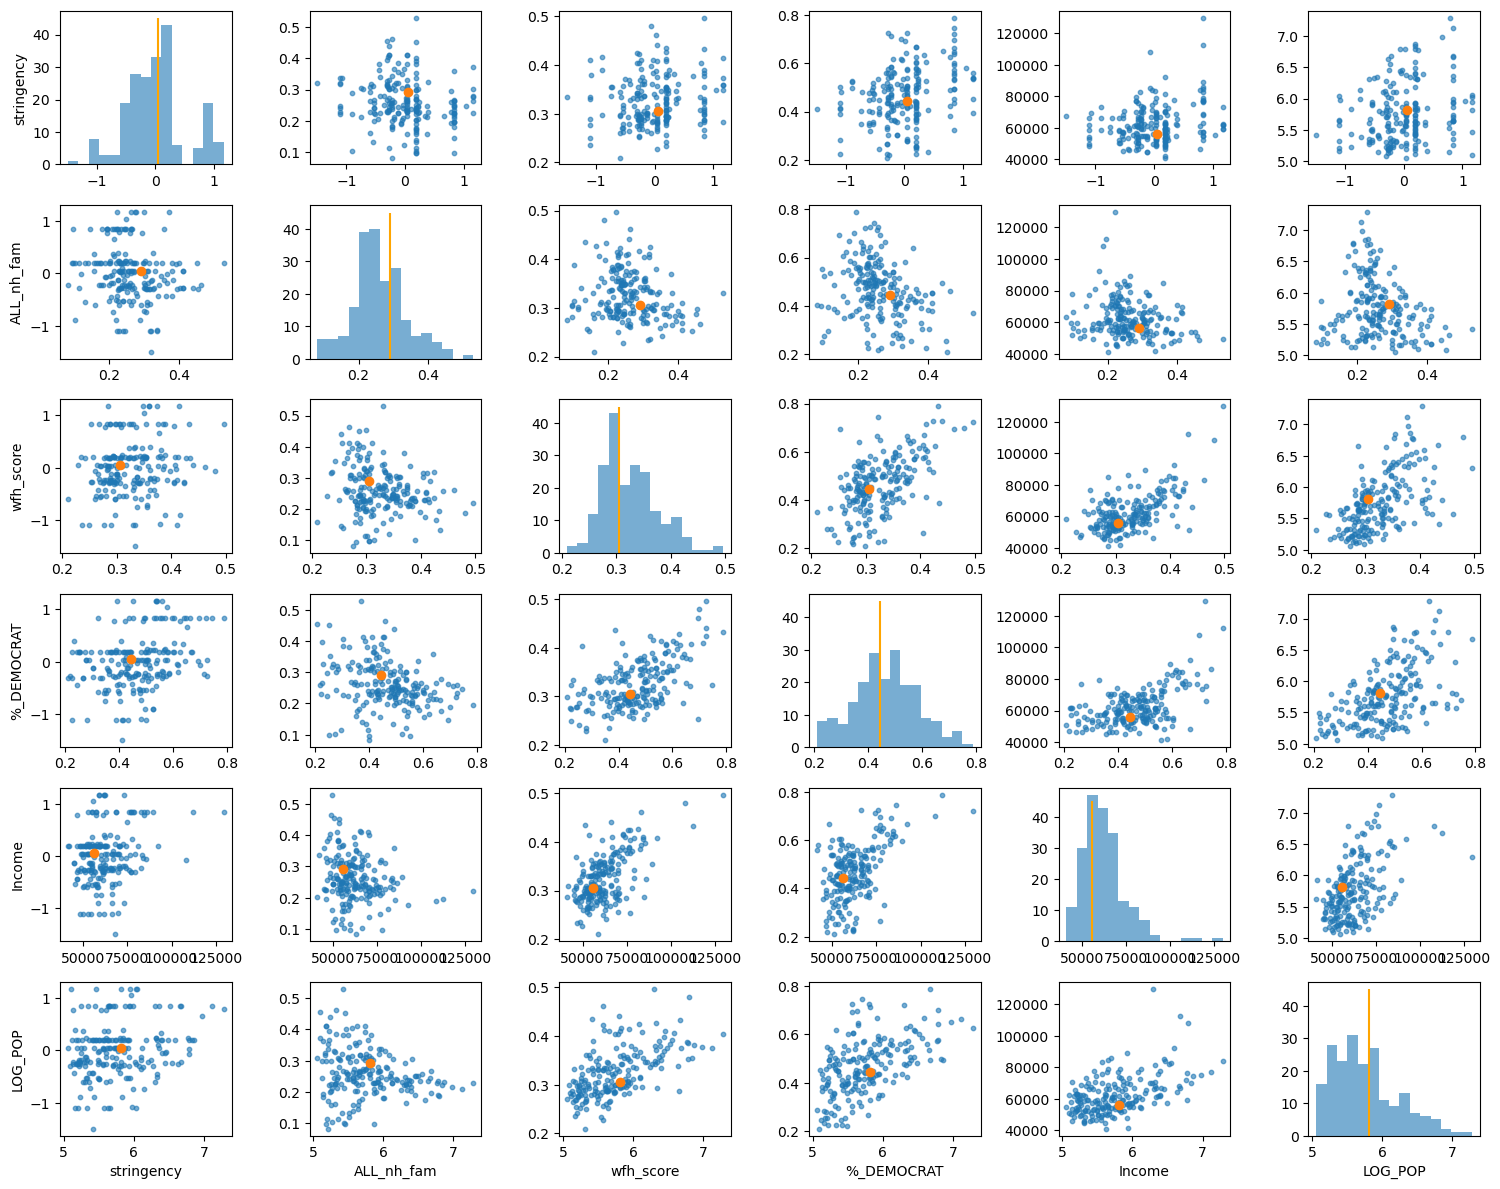

In [ ]:
keys = list(feature_modes.keys())

fig, axes = plt.subplots(len(keys), len(keys), figsize=(15,12))

for idx, k1 in enumerate(keys):
    axes[len(keys)-1, idx].set_xlabel(k1)
    axes[idx, 0].set_ylabel(k1)
    for jdx, k2 in enumerate(keys):
        if idx != jdx:
            axes[idx, jdx].scatter(df_q34[k1], df_q34[k2], s=10, alpha=0.6)
            axes[idx, jdx].scatter(feature_modes[k1], feature_modes[k2])
        else:
            axes[idx, jdx].hist(df_q34[k1],bins=15, alpha=0.6)
            axes[idx, jdx].vlines(feature_modes[k1], 0, 45, color='orange')
plt.tight_layout()

In [ ]:
kde_vars = ['stringency',   'ALL_nh_fam',   'wfh_score',    'stay_home',    '%_DEMOCRAT',   'Income',   'LOG_POP']
res =       [50j,            5j,            5j,             50j,            1j,             1j,         50j]
mode_dims = [ '%_DEMOCRAT', 'Income']
target = 'stay_home'
bw = 1.5
w = None
x_dim = 'LOG_POP'
y_dim = 'stringency'
xx_dim = 'wfh_score'
yy_dim = 'ALL_nh_fam'
c_dim = 'stay_home'
sliced = [1,3]
cmap = 'inferno'

kde_df = ndim_kde(df_q34, kde_vars, mode_dims, res, target, bw, w, feature_modes)
plot_kde_4panel(kde_df, x_dim, y_dim, xx_dim, yy_dim, c_dim, sliced, cmap)

In [ ]:
kde_vars = ['stringency',   'ALL_nh_fam',   'wfh_score',    'stay_home',    '%_DEMOCRAT',   'Income',   'LOG_POP']
res =       [50j,            5j,            1j,             50j,            5j,             1j,         50j]
mode_dims = [ 'wfh_score', 'Income']
target = 'stay_home'
bw = 1.5
w = None
x_dim = 'LOG_POP'
y_dim = 'stringency'
xx_dim = '%_DEMOCRAT'
yy_dim = 'ALL_nh_fam'
c_dim = 'stay_home'
sliced = [1,3]
cmap = 'inferno'

kde_df = ndim_kde(df_q34, kde_vars, mode_dims, res, target, bw, w, feature_modes)
plot_kde_4panel(kde_df, x_dim, y_dim, xx_dim, yy_dim, c_dim, sliced, cmap)

In [ ]:
def plot_kde_2panel(df, x_dim, y_dim, xx_dim, c_dim, sliced, cmap):
    xx_vars = sorted(df[xx_dim].unique())
    xs = xx_vars[sliced[0]], xx_vars[sliced[1]]
    cdf = df[df[xx_dim].isin(xs)]
    minz = cdf[c_dim].min()
    maxz = cdf[c_dim].max()
    fig, ax = plt.subplots(2, figsize=(6,8), sharex=True, sharey=True, facecolor='white')
    for idx, xv in enumerate(xs):
        tdf = df[df[xx_dim]==xv].copy()
        tdf = tdf[[x_dim,y_dim,c_dim]].groupby([x_dim, y_dim]).max().reset_index()
        dfp = pd.pivot(tdf, index=y_dim, columns=x_dim, values=c_dim)
        X,Y = np.meshgrid(dfp.columns.tolist(), dfp.index.tolist())
        Z = dfp.to_numpy() 
        levels = np.linspace(minz, maxz, 12)
        plot = ax[idx].contourf(X, Y, Z, levels=levels, cmap=cmap)
        ax[idx].set_xlabel(x_dim)
        ax[idx].set_ylabel(y_dim)
        title = f'{xx_dim}={str(xv)[0:4]}'
        ax[idx].set_title(title)
    plt.tight_layout()
    fig.colorbar(plot, ax=ax.ravel().tolist(), label=f'{c_dim}', pad=0.02)
    plt.show()

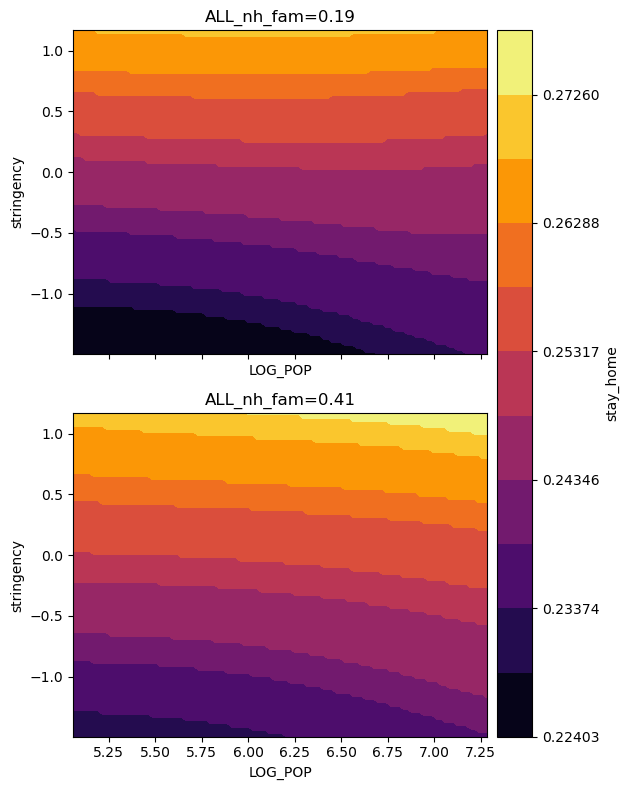

In [ ]:
kde_vars = ['stringency',   'ALL_nh_fam',   'wfh_score',    'stay_home',    '%_DEMOCRAT',   'Income',   'LOG_POP']
res =       [100j,            5j,            1j,             50j,            1j,             1j,         100j]
mode_dims = [ 'wfh_score', 'Income','%_DEMOCRAT']
target = 'stay_home'
bw = 1.5
w = None
x_dim = 'LOG_POP'
y_dim = 'stringency'
xx_dim = 'ALL_nh_fam'
c_dim = 'stay_home'
sliced = [1,3]
cmap = 'inferno'

kde_df = ndim_kde(df_q34, kde_vars, mode_dims, res, target, bw, w, feature_modes)
plot_kde_2panel(kde_df, x_dim, y_dim, xx_dim, c_dim, sliced, cmap)

In [ ]:
c_dim

'stay_home'

In [ ]:
kde_vars = ['stringency',   'ALL_nh_fam',   'wfh_score',    'stay_home',    '%_DEMOCRAT',   'Income',   'LOG_POP']
res =       [30j,            5j,            1j,             1000j,            1j,             1j,         30j]
mode_dims = [ 'wfh_score', 'Income','%_DEMOCRAT']
target = 'stay_home'
bw = 1.5
w = None
x_dim = 'LOG_POP'
y_dim = 'stringency'
xx_dim = 'ALL_nh_fam'
c_dim = 'stay_home'
sliced = [1,3]
cmap = 'inferno'

kde_df = ndim_kde(df_q34, kde_vars, mode_dims, res, target, bw, w, feature_modes)

xxs = kde_df[xx_dim].unique()

hf_df = kde_df[kde_df[xx_dim] == xxs[3]].copy()
lf_df = kde_df[kde_df[xx_dim] == xxs[1]].copy()
hf_df = hf_df[[x_dim,y_dim,c_dim]]
lf_df = lf_df[[x_dim,y_dim,c_dim]]
hf_df = hf_df.rename(columns={c_dim: c_dim+'_high'})
lf_df = lf_df.rename(columns={c_dim: c_dim+'_low'})
qdf = hf_df.merge(lf_df, on=[x_dim, y_dim])
del hf_df, lf_df

q = 'quotient'
qdf[q] = qdf[c_dim+'_high'] / qdf[c_dim+'_low']
display(qdf)


qdf = qdf[[x_dim,y_dim,q]].groupby([x_dim, y_dim]).max().reset_index()
dfp = pd.pivot(qdf, index=y_dim, columns=x_dim, values=q)
X,Y = np.meshgrid(dfp.columns.tolist(), dfp.index.tolist())
Z = dfp.to_numpy() 
levels = np.linspace(qdf[q].min(), qdf[q].max(), 12)


plt.contourf(X, Y, Z, levels=levels, cmap=cmap)
plt.xlabel(x_dim)
plt.ylabel(y_dim)

plt.tight_layout()
plt.colorbar(pad=0.02, label='m(g)|f(g)_{high} / m(g)|f(g)_{low}')
plt.show()

LOG_POP  stringency  stay_home_high  stay_home_low  quotient
0    5.058160    -1.49381        0.229254       0.222539  1.030174
1    5.134963    -1.49381        0.229254       0.222539  1.030174
2    5.211765    -1.49381        0.229418       0.222703  1.030152
3    5.288567    -1.49381        0.229418       0.222703  1.030152
4    5.365369    -1.49381        0.229581       0.222703  1.030888
..        ...         ...             ...            ...       ...
895  6.978218     1.16653        0.274621       0.269216  1.020076
896  7.055021     1.16653        0.274948       0.269052  1.021914
897  7.131823     1.16653        0.275276       0.268888  1.023755
898  7.208625     1.16653        0.275603       0.268888  1.024973
899  7.285428     1.16653        0.276095       0.268888  1.026800

[900 rows x 5 columns]

# TO DO

1. create plot layout w/ Dual plots at left, single plot top right, and univariate KDE plots for remaining variables at bottom right, showing modes selected as controls
2. For the above, repeat the prior analysis but exchanging variables to compare against other predictors
3. Fit poisson distributions to travel, use lambda and n for 2020/2019 as other measures of mobility, repeat #2


Possible investigation: 
1. Use google mobility data & DOT data (normalized to the same period- Jan3 to Feb6) and compare stayed_home with residential_mobility

# Exploratory Plot

In [ ]:
def grid_spec_plot():
    from matplotlib.gridspec import GridSpec

    # def format_axes(fig):
    #     for i, ax in enumerate(fig.axes):
    #         ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
    #         ax.set_ylabel("ydim")
    #         ax.set_xlabel('xdim')
    #         #ax.tick_params(labelbottom=False, labelleft=False)

    fig = plt.figure(layout="constrained", figsize=(14,8))
    gs = GridSpec(17, 19, figure=fig, wspace=2, hspace=2)#, width_ratios=widths)
    ax1 = fig.add_subplot(gs[0:8, 0:7])
    ax2 = fig.add_subplot(gs[9:18, 0:7])
    ax3 = fig.add_subplot(gs[:, 8:9])
    ax4 = fig.add_subplot(gs[0:8, 10:17])
    ax5 = fig.add_subplot(gs[0:8, 18:19])
    ax6 = fig.add_subplot(gs[9:11, 10:19])
    ax7 = fig.add_subplot(gs[12:14, 10:19])
    ax8 = fig.add_subplot(gs[15:17, 10:19])

    #fig.suptitle("GridSpec")
    #format_axes(fig)
    #plt.show()

    return fig, [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

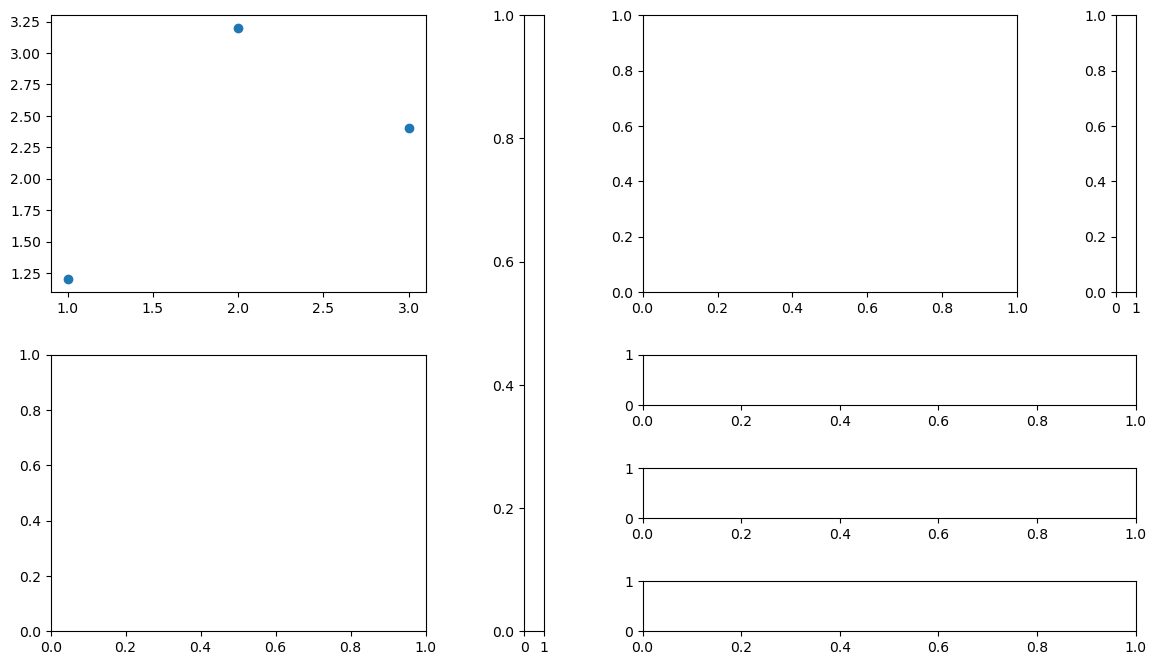

In [ ]:
fig, axes = grid_spec_plot()
axes[0].scatter([1,2,3], [1.2, 3.2, 2.4])

In [11]:
data_df = df_q34[['stay_home', 'ALL_nh_fam']].copy()
varx = 'ALL_nh_fam'
vary = 'stay_home'

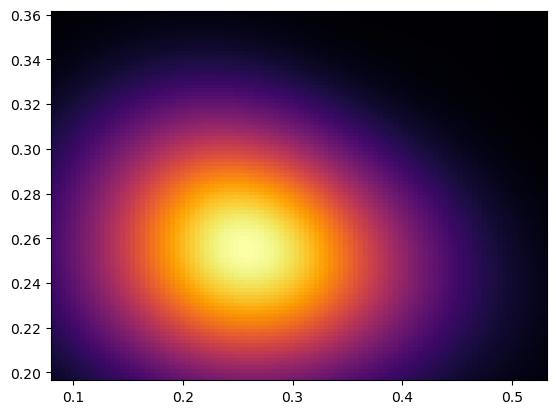

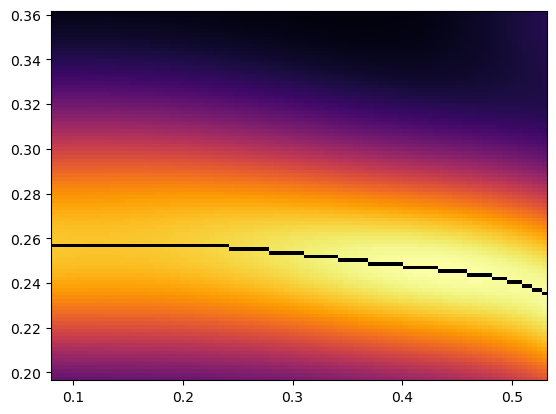

In [37]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

resolution = 100
bandwidth = 1

x = data_df[varx]
y = data_df[vary]
kde = stats.gaussian_kde(np.vstack([x,y]), bw_method=bandwidth)
x_grid = np.linspace(min(x), max(x), resolution)
y_grid = np.linspace(min(y), max(y), resolution)
X, Y = np.meshgrid(x_grid, y_grid)
Z = kde.evaluate(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

plt.pcolormesh(X,Y,Z, cmap='inferno')
plt.show()

Zt = Z.T
for i in range(len(Zt)):
    Zt[i] = Zt[i] / sum(Zt[i])
    m = max(Zt[i])
    Zt[i] = np.array([j if j!=m else 0 for j in Zt[i]])
Z = Zt.T

plt.pcolormesh(X,Y,Z, cmap='inferno')



In [33]:
Zt[i]

array([0.01180799, 0.01231952, 0.01282582, 0.01332485, 0.01381463,
       0.01429316, 0.0147585 , 0.01520875, 0.01564207, 0.0160567 ,
       0.01645095, 0.01682321, 0.017172  , 0.01749588, 0.01779357,
       0.01806387, 0.01830568, 0.01851804, 0.01870009, 0.01885109,
       0.01897042, 0.01905758, 0.01911218, 0.01913398, 0.01912285,
       0.01907878, 0.01900192, 0.01889253, 0.01875101, 0.01857789,
       0.01837386, 0.01813974, 0.01787647, 0.01758515, 0.017267  ,
       0.0169234 , 0.01655581, 0.01616586, 0.01575526, 0.01532582,
       0.01487948, 0.0144182 , 0.01394407, 0.01345918, 0.01296569,
       0.01246577, 0.01196157, 0.01145528, 0.01094901, 0.01044485,
       0.00994484, 0.00945093, 0.00896499, 0.00848879, 0.00802399,
       0.00757214, 0.00713465, 0.00671282, 0.00630779, 0.00592058,
       0.00555204, 0.00520292, 0.00487379, 0.0045651 , 0.00427715,
       0.00401012, 0.00376404, 0.00353884, 0.00333429, 0.00315007,
       0.00298575, 0.00284077, 0.0027145 , 0.00260619, 0.00251